<a href="https://colab.research.google.com/github/olusegunadelowo/FaceBook-Prophet-with-Household-Electricity-Consumption-Time-Series-Data/blob/main/Univariate_and_Multivariate_Forecast_of_Electricity_Consumption_with_facebookProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.  Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

# 2. Import Dataset

In [ ]:
#Mounting the content of google drive (the content includes our dataset)
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [61]:
#importing the dataset from google drive
Energy_data = pd.read_csv("/content/gdrive/MyDrive/Data Science Projects/hamoyeInternship/Stage E - Time Series /household_power_consumption.csv",
                           sep=';', low_memory=False)

# 3. Data Wrangling

# **Question 11-13**

In [62]:
#Preview the 1st 5 rows of the table
Energy_data.head(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [63]:
#Check shape of the dataset
Energy_data.shape

(2075259, 9)

## 3.1 Convert to datetime format YYYY-MM-DD HH:MM:SS

In [64]:
#merge the date and time columns and form a new column called DateTime
Energy_data["DateTime"] = Energy_data["Date"] +" "+ Energy_data["Time"]
#delete Date and Time Columns that have been merged
Energy_data.drop(Energy_data.iloc[:, 0:2], inplace=True, axis=1)
#convert DateTime column to datetime format YYYY-MM-DD HH:MM:SS
Energy_data["DateTime"] = pd.to_datetime(Energy_data["DateTime"])
#Set DateTime column to index
Energy_data.set_index("DateTime", inplace=True)
#Preview the 1st 7 observations
Energy_data.head(7)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
2006-12-16 17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
2006-12-16 17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0


## 3.2 Treat missing values and Change Columns' Datatypes

In [65]:
#check for missing values
Energy_data.isnull().values.any()

True

`Observation` : There are missing values

In [66]:
#Check columns datatypes
Energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


`Observation` : On the CSV file, all columns protrayed as object/string are actually not.They are showing as object because of the presence of a string '?'

In [67]:
#replace ? with 0
Energy_data = Energy_data.replace('?', 0)

In [68]:
#check sum of missing data
Energy_data.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

`Observation` : Sub_metering_3 has missing values of 25979

In [69]:
#Filling missing data by imputation - Forward fill
Energy_data = Energy_data.fillna(method='ffill')
Energy_data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [70]:
Energy_data.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [71]:
#Convert all columns except DateTime to float data types
Energy_data[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']] = Energy_data[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']].astype(float)
Energy_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [72]:
#Re-check columns datatypes
Energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


Text(0, 0.5, 'Global_active_power')

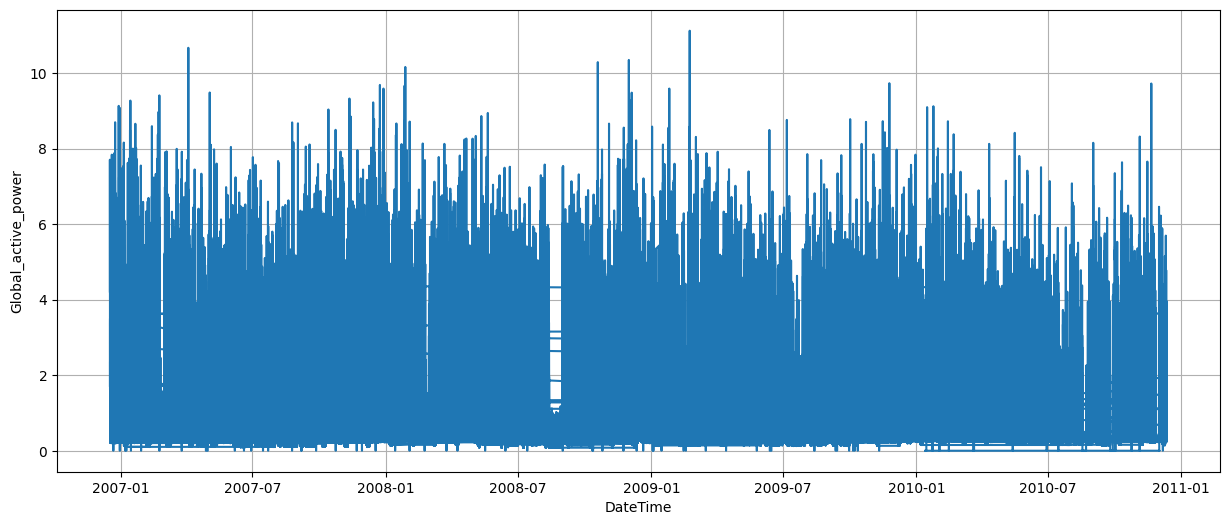

In [73]:
#time-series plot of Global_active_power reading against time

plt.figure(figsize=(15,6))
plt.plot(Energy_data.index, Energy_data.Global_active_power)
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Global_active_power')

`Observation`: It's difficult to recognize patterns because our dataset has too many samples 2075259

# **Question 14-16**

## 3.4 Resampling Target Variable

In [74]:
#resampling(downsampling) for Global_active_power readings to 1 day.
Energy_data["Global_active_power"].resample("D").mean().head(7)

DateTime
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
2006-12-21    1.192100
2006-12-22    1.625929
Freq: D, Name: Global_active_power, dtype: float64

In [75]:
#Find out how many missing values
Energy_data["Global_active_power"].resample("D").mean().isnull().sum()

15

In [76]:
#Check that their's not missing value again
Energy_data["Global_active_power"].resample("D").mean().fillna(method = "ffill").head().isnull().sum()

0

Text(0, 0.5, 'Global_active_power')

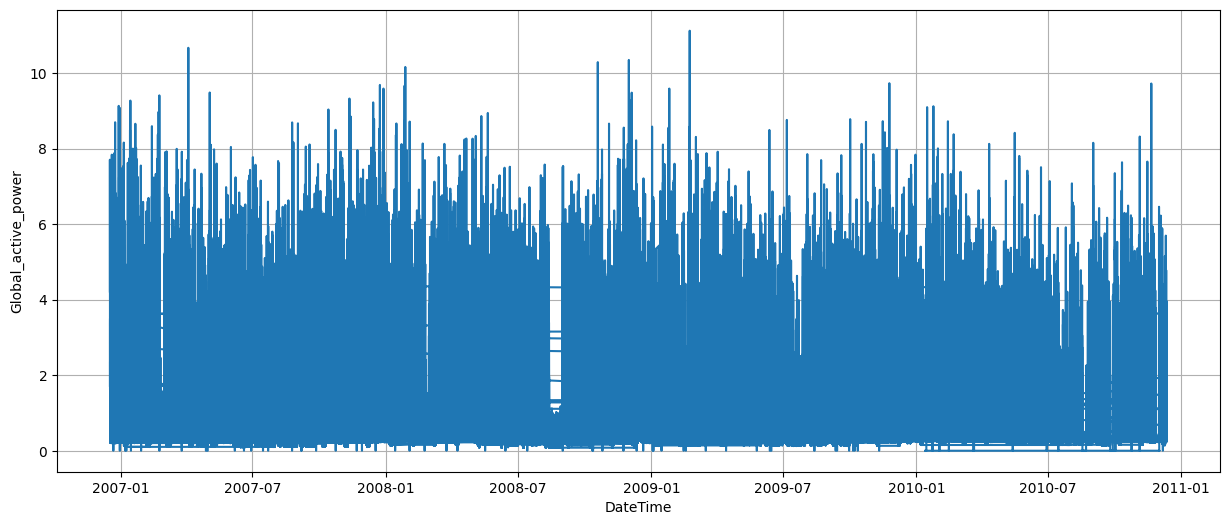

In [77]:
plt.figure(figsize=(15,6))
plt.plot(Energy_data.index, Energy_data.Global_active_power)
plt.grid()
plt.xlabel('DateTime')
plt.ylabel('Global_active_power')

`Observation`: The undersampling of target variable does not have any effect on the pattern.The pattern remained the same

# **Univariate time series modeling with Facebook Phrophet**

In [78]:
from prophet import Prophet

In [37]:
Energy_data_prophet = pd.DataFrame(Energy_data['Global_active_power'])
Energy_data_prophet.index = pd.to_datetime(Energy_data_prophet.index)
Energy_data_prophet.head(5)

,Global_active_power
DateTime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [38]:
Energy_data_prophet.tail(300)

,Global_active_power
DateTime,
2010-11-26 16:03:00,0.412
2010-11-26 16:04:00,0.410
2010-11-26 16:05:00,0.408
2010-11-26 16:06:00,0.528
2010-11-26 16:07:00,0.522
...,...
2010-11-26 20:58:00,0.946
2010-11-26 20:59:00,0.944
2010-11-26 21:00:00,0.938


In [40]:
# split data into train and test test
train = Energy_data_prophet.copy().loc["2006-12-16 17:24:00":"2010-11-26 16:02:00"]    #train = X - 300 rows. X is Energy_data_prophet
test = Energy_data_prophet.copy().loc["2010-11-26 16:03:00":"2010-11-26 21:02:00"]     #test = 300 rows.

train.reset_index(inplace=True)
test.reset_index(inplace=True)

train.columns = ['ds', 'y']
test.columns = ['ds', 'y']

print("Train Shape: {}, Test Shape: {}".format(train.shape, test.shape))

Train Shape: (2059119, 2), Test Shape: (300, 2)


In [41]:
train.head(4)

,ds,y
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388


In [42]:
test.head(4)

,ds,y
0,2010-11-26 16:03:00,0.412
1,2010-11-26 16:04:00,0.410
2,2010-11-26 16:05:00,0.408
3,2010-11-26 16:06:00,0.528


In [43]:
#Train facebook prophet algorithm to recognize pattern in the train data.
model = Prophet()
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplbspa_6_/fv09ifz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbspa_6_/y5yt8o06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40339', 'data', 'file=/tmp/tmplbspa_6_/fv09ifz_.json', 'init=/tmp/tmplbspa_6_/y5yt8o06.json', 'output', 'file=/tmp/tmplbspa_6_/prophet_modelurvc4h4b/prophet_model-20231204143708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# **Question 17-20**

# **Multivariate Time Series Forecasting with Facebook Prophet**

In [79]:
Energy_data_prophet_2 = Energy_data[['Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_1','Sub_metering_2','Sub_metering_3','Global_active_power']].reset_index()
Energy_data_prophet_2.head()

,DateTime,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power
0,2006-12-16 17:24:00,0.418,234.84,18.4,0.0,1.0,17.0,4.216
1,2006-12-16 17:25:00,0.436,233.63,23.0,0.0,1.0,16.0,5.360
2,2006-12-16 17:26:00,0.498,233.29,23.0,0.0,2.0,17.0,5.374
3,2006-12-16 17:27:00,0.502,233.74,23.0,0.0,1.0,17.0,5.388
4,2006-12-16 17:28:00,0.528,235.68,15.8,0.0,1.0,17.0,3.666


In [45]:
Energy_data_prophet_2.tail(300)

,DateTime,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power
2074959,2010-11-26 16:03:00,0.076,242.77,1.6,0.0,2.0,0.0,0.412
2074960,2010-11-26 16:04:00,0.076,242.45,1.6,0.0,1.0,0.0,0.410
2074961,2010-11-26 16:05:00,0.074,242.18,1.6,0.0,1.0,0.0,0.408
2074962,2010-11-26 16:06:00,0.212,242.60,2.4,0.0,2.0,0.0,0.528
2074963,2010-11-26 16:07:00,0.214,242.91,2.2,0.0,1.0,0.0,0.522
...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.000,240.43,4.0,0.0,0.0,0.0,0.946
2075255,2010-11-26 20:59:00,0.000,240.00,4.0,0.0,0.0,0.0,0.944
2075256,2010-11-26 21:00:00,0.000,239.82,3.8,0.0,0.0,0.0,0.938
2075257,2010-11-26 21:01:00,0.000,239.70,3.8,0.0,0.0,0.0,0.934


In [50]:
Energy_data_prophet_2.shape

(2075259, 8)

In [ ]:
#X_train = Energy_data_prophet_2.copy().iloc[0:2059119,0:7]
#y_train =  Energy_data_prophet_2.copy().iloc[0:2059119,-1]

#X_test  = Energy_data_prophet_2.copy().iloc[2074959:2075259,0:7]
#y_test  = Energy_data_prophet_2.copy().iloc[2074959:2075259,-1]


In [ ]:
# split data into train and test test

train_2 = Energy_data_prophet_2.loc["2006-12-16 17:24:00":"2010-11-26 16:02:00"]                               # train_2 = X - 300 rows. X is Energy_data_prophet

test_2 = Energy_data_prophet_2.loc["2010-11-26 16:03:00":"2010-11-26 21:02:00"]                                # test_2 = 300 rows.

#train_2.reset_index(inplace=True)
#test_2.reset_index(inplace=True)

train_2.columns = ['ds','add1', 'add2', 'add3', 'add4', 'add5',' add6','y']
test_2.columns =  ['ds', 'add1', 'add2', 'add3', 'add4', 'add5',' add6','y']

print("Train Shape: {}, Test Shape: {}".format(train_2.shape, test_2.shape))

In [59]:
model = Prophet()
model.fit(train_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbspa_6_/_1ier7p5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplbspa_6_/tq3ae2gi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97041', 'data', 'file=/tmp/tmplbspa_6_/_1ier7p5.json', 'init=/tmp/tmplbspa_6_/tq3ae2gi.json', 'output', 'file=/tmp/tmplbspa_6_/prophet_model_gtk6771/prophet_model-20231204153245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:32:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
